In [1]:
import torch

def check_mps_availability():
    # MPS 사용 가능 여부를 확인합니다.
    if torch.backends.mps.is_available():
        print("이 장치에서 MPS(GPU 가속)를 사용할 수 있습니다.")
    else:
        print("MPS를 사용할 수 없습니다. CPU를 사용합니다.")

#  GPU 사용 가능 여부를 확인합니다.
check_mps_availability()

이 장치에서 MPS(GPU 가속)를 사용할 수 있습니다.


In [2]:
import matplotlib.pyplot as plt

def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

In [3]:
import pandas as pd

dataset = pd.read_csv('./IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


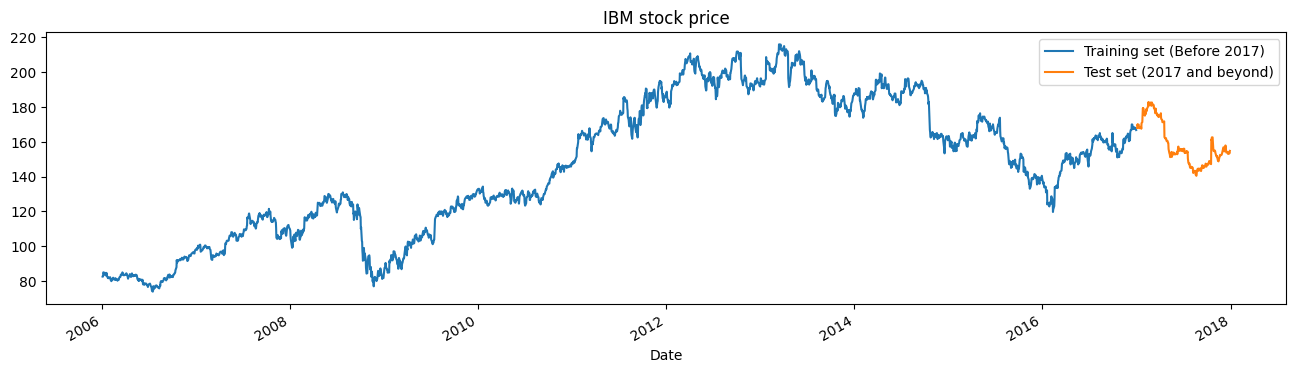

In [ ]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)

plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [5]:
import torch
import torch.nn as nn
import numpy as np
from typing import List

class StockLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, dropout=0.2):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x, future_steps=1):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        if future_steps > 1:
            predictions = [out]
            for _ in range(future_steps - 1):
                out, _ = self.lstm(out.unsqueeze(1), (h0, c0))
                out = self.fc(out[:, -1, :])
                predictions.append(out)
            return torch.cat(predictions, dim=1)
        return out

def load_model(model_path: str = "models/stock_lstm.pth") -> StockLSTM:
    """
    학습된 LSTM 모델을 로드합니다.
    """
    model = StockLSTM()
    try:
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model
    except FileNotFoundError:
        raise Exception(f"모델 파일을 찾을 수 없습니다: {model_path}")

def preprocess_data(data: np.ndarray, seq_length: int = 20) -> np.ndarray:
    """
    주가 데이터를 전처리합니다. (정규화 및 시퀀스 생성)
    """
    data_min, data_max = data.min(), data.max()
    normalized = (data - data_min) / (data_max - data_min + 1e-7)
    
    if len(normalized) < seq_length:
        raise ValueError(f"입력 데이터 길이({len(normalized)})가 최소 시퀀스 길이({seq_length})보다 짧습니다.")
    
    return normalized[-seq_length:].reshape(-1, 1)

def calculate_rmse(predictions: np.ndarray, actual: np.ndarray) -> float:
    """
    예측값과 실제값 간의 RMSE를 계산합니다.
    """
    if len(predictions) != len(actual):
        raise ValueError("예측값과 실제값의 길이가 일치하지 않습니다.")
    mse = np.mean((predictions - actual) ** 2)
    return float(np.sqrt(mse))

In [6]:
def predict(input_data):
    try:
        model = load_model()
        preprocessed_data = preprocess_data(np.array(input_data.sequence))
        
        with torch.no_grad():
            model.eval()
            tensor_input = torch.tensor(preprocessed_data, dtype=torch.float32).unsqueeze(0)
            predictions = model(tensor_input, future_steps=input_data.future_steps)
            predictions = predictions.squeeze().tolist()
            
        return predictions
    except Exception as e:
        raise Exception(f"예측 중 오류 발생: {str(e)}")


In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from services.model import StockLSTM, preprocess_data


def train_model(df, epochs: int, learning_rate: float, batch_size: int) -> dict:
    """
    LSTM 모델을 학습시킵니다.
    """
    prices = df['Close'].values  # 종가 데이터 사용
    
    # 데이터 전처리
    seq_length = 20
    sequences = []
    targets = []
    for i in range(len(prices) - seq_length):
        sequences.append(prices[i:i + seq_length])
        targets.append(prices[i + seq_length])
    
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    # 정규화
    sequences = preprocess_data(sequences.flatten()).reshape(-1, seq_length, 1)
    targets = (targets - targets.min()) / (targets.max() - targets.min() + 1e-7)
    
    # 데이터셋 생성
    dataset = TensorDataset(
        torch.tensor(sequences, dtype=torch.float32),
        torch.tensor(targets, dtype=torch.float32).unsqueeze(1)
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # 모델 초기화
    model = StockLSTM()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # 학습 루프
    final_loss = 0.0
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        for batch_seq, batch_target in dataloader:
            optimizer.zero_grad()
            output = model(batch_seq)
            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        final_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {final_loss}")
    
    # 모델 저장
    torch.save(model.state_dict(), "models/stock_lstm.pth")
    
    return {
        "status": "success",
        "message": "Model training completed successfully",
        "final_loss": final_loss
    }

In [ ]:
def train(input_data):
    """
    LSTM 모델을 학습시킵니다.
    """
    try:
        result = train_model(
            epochs=input_data.epochs,
            learning_rate=input_data.learning_rate,
            batch_size=input_data.batch_size
        )
        return result
    except Exception as e:
        raise Exception(f"모델 학습 중 오류 발생: {str(e)}")